
### Imports
This demo only uses basic packages like numpy, etc. Specific RC packages like reservoirpy and pyrcn can speed things up.

In [286]:
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import plotly.express as px

from scipy.integrate import solve_ivp

from sklearn.linear_model import RidgeCV

from IPython.display import display

# RC packages:
import reservoirpy as rpy
import pyrcn


Lorenz system

In [287]:
def lorenz_derivative(x):
    return np.array([10 * (x[1] - x[0]), x[0] * (28 - x[2]) - x[1], x[0] * x[1] - (8/3) * x[2]])

def lorenz_wrapper(t, x):
    return lorenz_derivative(x)

T = 10000
T_burn = 10
dt = 0.01
t_span = [0, T + T_burn]
t_eval = np.linspace(T_burn, T + T_burn, int(T/dt))
lorenz_solution = solve_ivp(lorenz_wrapper, t_span, np.random.randn(3), t_eval=t_eval)

fig = px.line_3d(lorenz_solution.y[:, :10000].T, x=0, y=1, z=2)
fig.update_layout(width=600, height=600)
fig.show()


Create the reservoir

In [288]:
def generate_ESN(N_nodes, N_in, desired_spectral_radius, input_scaling, connection_probability, plot_on=False):
    # Internal connectivity
    W_res = (np.random.rand(N_nodes, N_nodes) < connection_probability) * np.random.randn(N_nodes, N_nodes)
    W_res = W_res * desired_spectral_radius / np.abs(np.linalg.eigvals(W_res)).max()
    display('spectral radius is {:.3f}'.format(np.abs(np.linalg.eigvals(W_res)).max()))

    W_in = -input_scaling + 2*input_scaling * np.random.rand(N_nodes, N_in)
    if plot_on:
        G = nx.from_numpy_array(W_res, create_using=nx.DiGraph)

        fig, ax = plt.subplots(figsize=[8,6])
        positions = nx.drawing.spring_layout(G)
        node_plot = nx.draw_networkx_nodes(G, pos=positions, node_size=10, ax=ax)
        edges = G.edges(data=True)
        edge_weights = np.array([e[2]['weight'] for e in edges])
        cmap = plt.get_cmap(name='PuOr_r')
        vmin=-1
        vmax=1
        edge_plot = nx.draw_networkx_edges(G, pos=positions, ax=ax, edge_color=edge_weights, edge_cmap=cmap, edge_vmin=vmin, edge_vmax=vmax)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm._A = []
        plt.colorbar(sm, label='edge weight')
        plt.title('reservoir connectivity')
    
    return W_res, W_in

def run_ESN(W_res, W_in, u, leakage=0, bias=None, r_0=None):
    N_nodes = W_res.shape[0]
    N_in, L = u.shape
    r = np.empty((N_nodes, L))
    if r_0 == None:
        r[:, 0] = np.random.rand(N_nodes)
    else:
        r[:, 0] = r_0
    if bias == None:
        bias = 0.1 * np.ones(N_nodes)
        
    for i in range(1, L):
        r[:, i] = leakage * r[:, i-1] + (1 - leakage) * np.tanh(W_res @ r[:, i-1] + W_in @ u[:, i] + bias)
    return r

# Generate reservoir    
N_nodes = 200
N_in = 3
desired_spectral_radius = 1
input_scaling = 1
connection_probability = 10/N_nodes
W_res, W_in = generate_ESN(N_nodes, N_in, desired_spectral_radius, input_scaling, connection_probability)

'spectral radius is 1.000'

#### Prepare the input
- What is the task?
- Sampling?
- Normalisation?

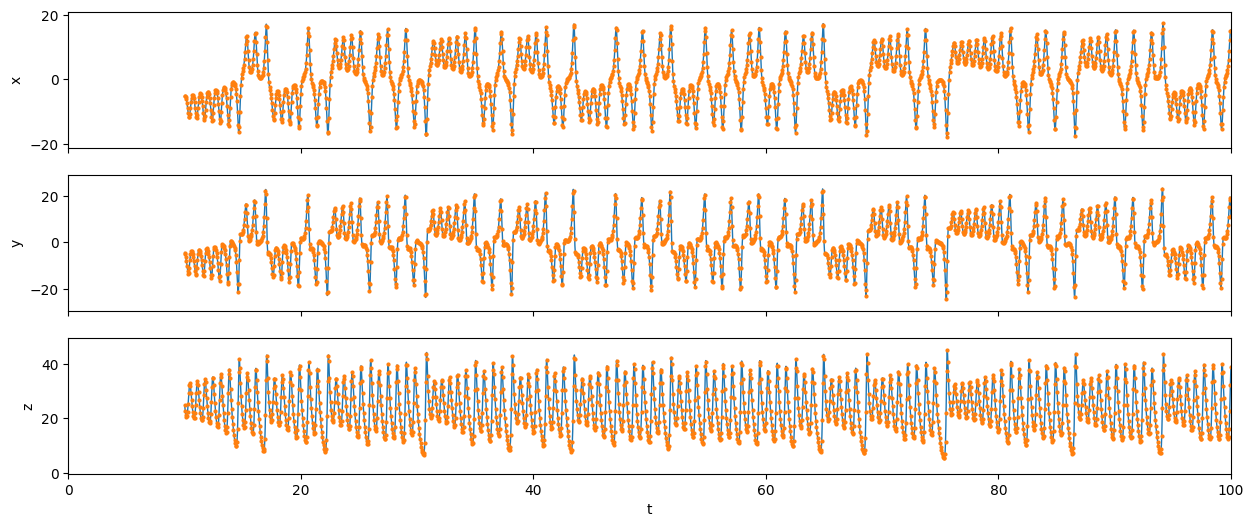

In [289]:
fig, axs = plt.subplots(3, 1, figsize=[15, 6], sharex='all', squeeze=True)
ylabels = ['x', 'y', 'z']
sampling = 5

for i, ax in enumerate(axs):
    ax.plot(lorenz_solution.t, lorenz_solution.y[i, :], lw=1)
    ax.plot(lorenz_solution.t[::sampling], lorenz_solution.y[i, ::sampling], '.', ms=4)
    ax.set_ylabel(ylabels[i])
    ax.set_xlim([0, 100])
    if i == 2:
        ax.set_xlabel('t')
    

In [290]:
# sub-sample Lorenz integration
u = lorenz_solution.y[:, ::sampling]

# normalise to mean-zero unit-standard-deviation
u = (u - u.mean(axis=1).reshape((3, 1))) / u.std(axis=1).reshape((3, 1))
display('means: {}'.format(u.mean(axis=1)))
display('standard deviations: {}'.format(u.std(axis=1)))

'means: [ 1.37845291e-17 -5.82645043e-18 -3.69171360e-16]'

'standard deviations: [1. 1. 1.]'

#### Run the reservoir

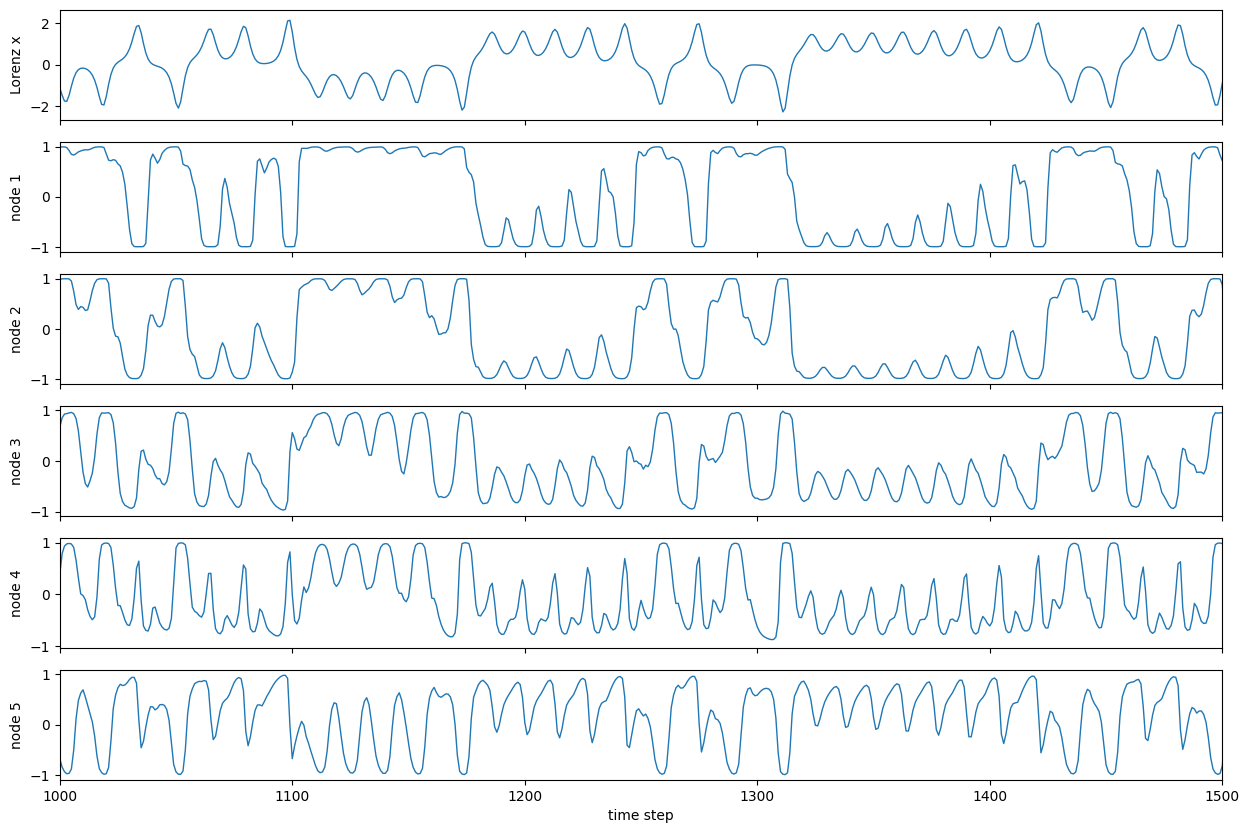

In [291]:
r = run_ESN(W_res, W_in, u)

fig, axs = plt.subplots(6, 1, figsize=[15, 10], sharex='all', squeeze=True)
for i, ax in enumerate(axs):
    if i == 0:
        ax.plot(u[0, :], lw=1)
        ax.set_ylabel('Lorenz x')
    else:
        ax.plot(r[i, :], lw=1)
        ax.set_ylabel('node {}'.format(i))
    ax.set_xlim([1000, 1500])
    if i == len(axs)-1:
        ax.set_xlabel('time step')

Check for the ESP

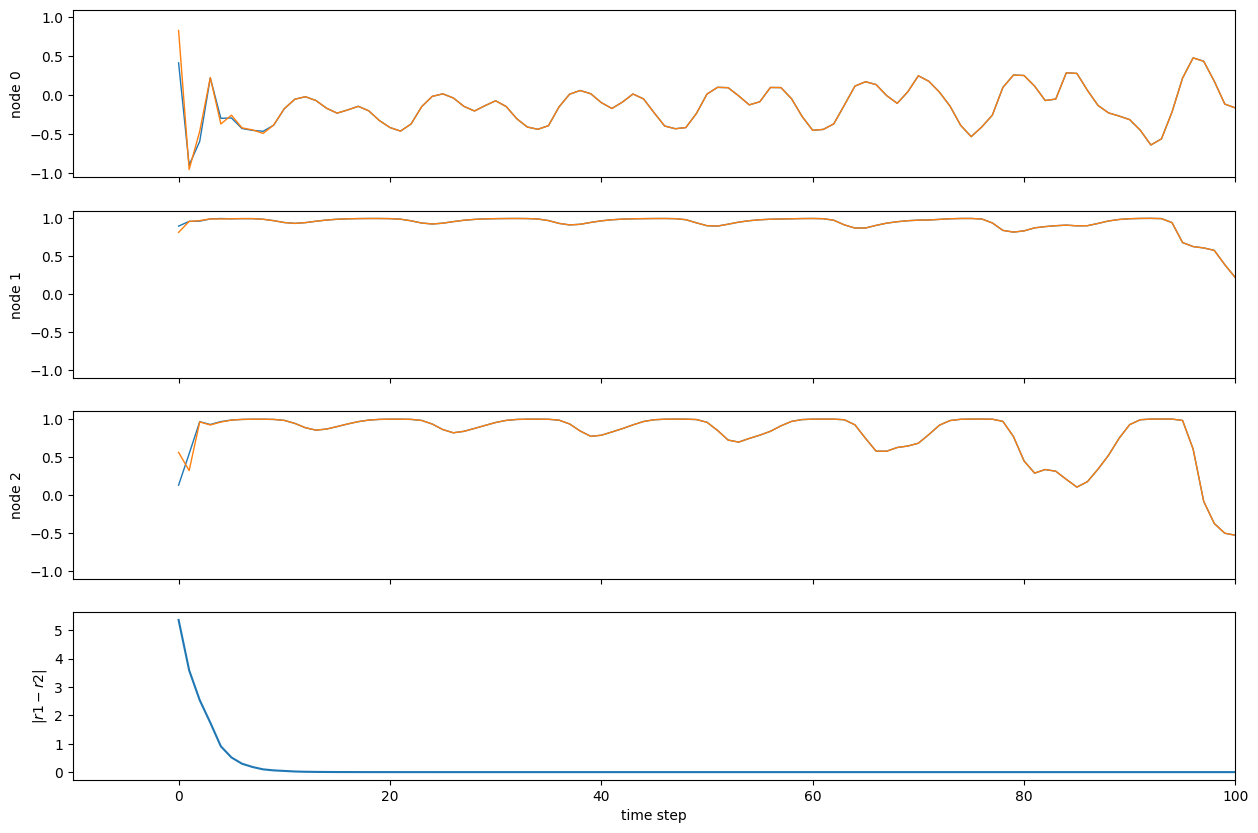

In [292]:
r1 = run_ESN(W_res, W_in, u)
r2 = run_ESN(W_res, W_in, u)

fig, axs = plt.subplots(4, 1, figsize=[15, 10], sharex='all', squeeze=True)
for i, ax in enumerate(axs):
    if i == 3:
        ax.plot(np.linalg.norm(r1 - r2, axis=0))
        ax.set_ylabel('$|r1 - r2|$')
    else:
        ax.plot(r1[i, :], lw=1)
        ax.plot(r2[i, :], lw=1)
        ax.set_ylabel('node {}'.format(i))
    ax.set_xlim([-10, 100])
    if i == len(axs)-1:
        ax.set_xlabel('time step')

#### Train the reservoir
- What is the task? What is the training method?
- Define the target
- Training, validation, testing

'prediction horizon: 1.000s (20 time steps)'

'NRMSE: 0.508'

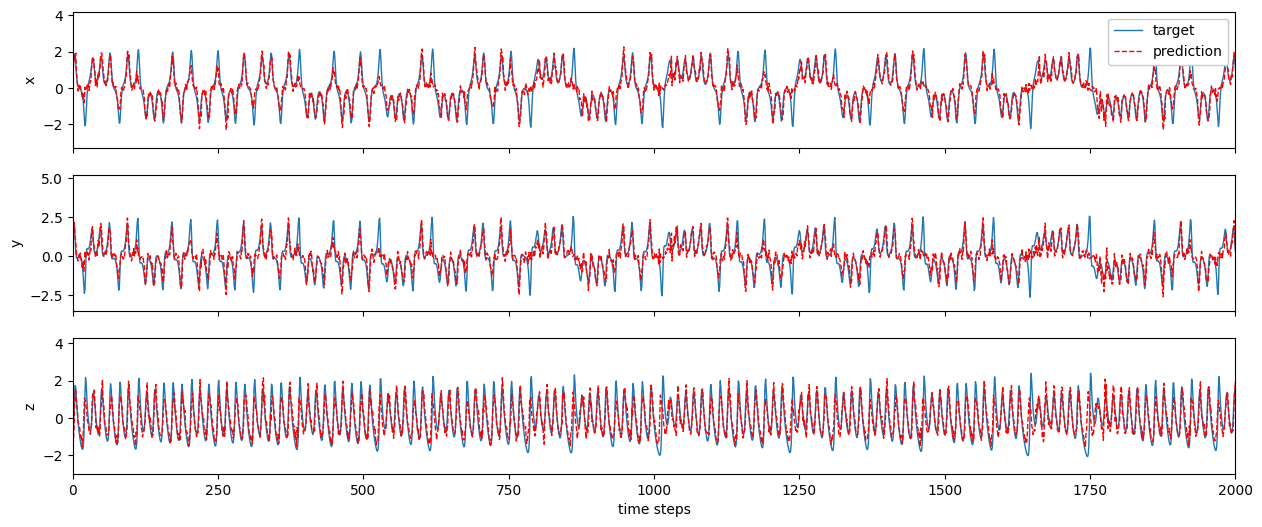

In [293]:
prediction_horizon = 1 #time units
tau = np.round(prediction_horizon / (dt * sampling)).astype(int)
display('prediction horizon: {:.3f}s ({} time steps)'.format(prediction_horizon, tau))
target = u[:, tau:]
X = r[:, :-tau]

# remove transient
target = target[:, 1000:]
X = X[:, 1000:]
X = X - X.mean(axis=1).reshape(-1, 1)
_, L = target.shape

# split into training, validation and testing sets
split1, split2 = np.round(0.5 * L).astype(int), np.round(0.75 * L).astype(int)
target_train, X_train = target[:, :split1], X[:, :split1]
target_val, X_val = target[:, split1+1:split2], X[:, split1+1:split2]
target_test, X_test = target[:, split2+1:], X[:, split2+1:]

# normalised-root-mean-squared-error (NRMSE)
def calc_NRMSE(truth, prediction):
    return (((truth - prediction) ** 2).mean(axis=1) ** (1/2) / truth.std(axis=1)).mean()


# ridge regression
ridge_parameters = 10 ** np.linspace(-7, 3, 21)
errors = {}
min_error = np.inf
for ridge_parameter in ridge_parameters:
    W_out = np.linalg.inv(X_train @ X_train.T + ridge_parameter * np.eye(N_nodes)) @ X_train @ target_train.T
    error = calc_NRMSE(target_val, W_out.T @ X_val)
    errors[ridge_parameter] = error
    if error < min_error:
        min_error = error
        best_ridge_param = ridge_parameter
        best_W_out = W_out
W_out = best_W_out

# plot test set
prediction = W_out.T @ X_test
error = calc_NRMSE(target_test, prediction)
display('NRMSE: {:.3f}'.format(error))

fig, axs = plt.subplots(3, 1, figsize=[15, 6], sharex='all', squeeze=True)
ylabels = ['x', 'y', 'z']

for i, ax in enumerate(axs):
    ax.plot(target_test[i, :], lw=1, label='target')
    ax.plot(prediction[i, :], 'r--', lw=1, label='prediction')
    ax.set_ylabel(ylabels[i])
    ax.set_xlim([0, 2000])
    if i == 0:
        ax.legend(loc='upper right', framealpha=1)
    if i == 2:
        ax.set_xlabel('time steps')